<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
!pip install modisco

In [1]:
from __future__ import print_function, division
%matplotlib inline
/
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
import os

TF-MoDISco is using the TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


/Users/avantishrikumar/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/avantishrikumar/Research/tfmodisco/modisco/seqlet_embedding/advanced_gapped_kmer.py:190: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('max_len', self.max_len)


## Grab the input data

In [4]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [3]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x)[::rc,::rc] for x in
                            f['contrib_scores'][task][:n] for rc in [1,-1]]
    task_to_hyp_scores[task] = [np.array(x)[::rc, ::rc] for x in
                                f['hyp_contrib_scores'][task][:n] for rc in [1,-1]]

onehot_data = [one_hot_encode_along_channel_axis(seq)[::rc, ::rc]
               for seq in fasta_sequences[:n]
               for rc in [1,-1]]

Double check by plotting

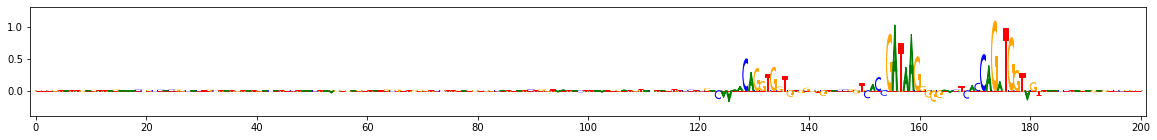

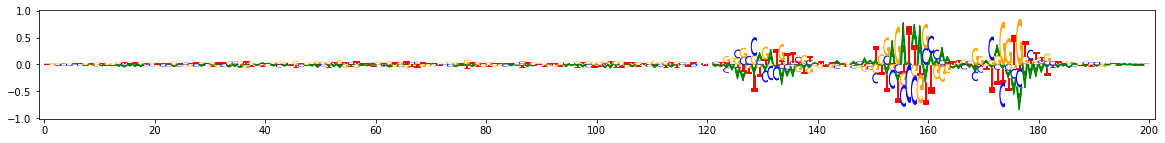

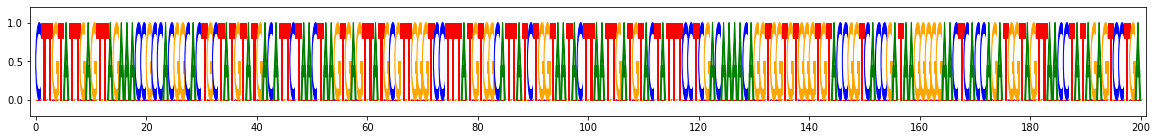

In [7]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.651464704
On task task0
Fitting - on window size 5
peak(mu)= 0.004865888827480376
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.2954850349262155 occurring at 5.7220458984375e-06 implying a frac_neg of 0.41941626448668695
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35928651361524633 occurring at -5.638343282043934e-06 implying a frac_neg of 0.5607600296390388
To be conservative, adjusted frac neg is 0.95


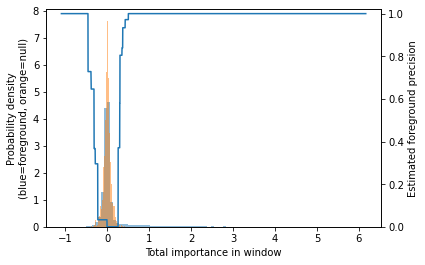

Fitting - on window size 9
peak(mu)= 0.0019212778508663174
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.31974367348777494 occurring at 6.765127182006836e-06 implying a frac_neg of 0.47003410483096586
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4258213778275138 occurring at -2.9428978450596333e-05 implying a frac_neg of 0.7416183072374903
To be conservative, adjusted frac neg is 0.95


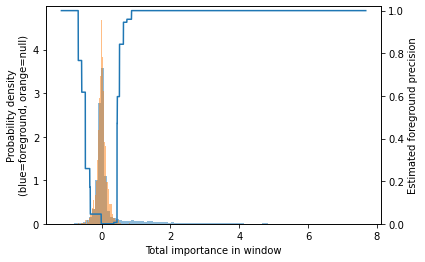

Fitting - on window size 13
peak(mu)= 0.014580504179000855
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.3469747405521833 occurring at 1.621246337890625e-05 implying a frac_neg of 0.5313343328335832
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.11749949829420027 occurring at -1.7642974853515625e-05 implying a frac_neg of 0.13314383172256963
To be conservative, adjusted frac neg is 0.95


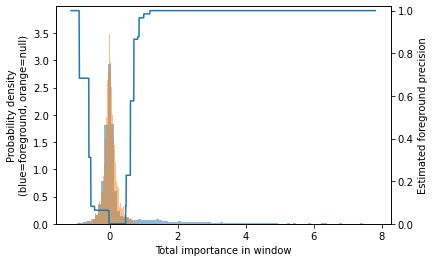

Fitting - on window size 17
peak(mu)= -0.03414142362773419
Computing window sums
Done computing window sums
For increasing = True , the minimum IR precision was 0.40074974232407007 occurring at 6.67572021484375e-06 implying a frac_neg of 0.6687518898670086
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.2519079426947738 occurring at -3.814697265625e-06 implying a frac_neg of 0.3367338821938512
To be conservative, adjusted frac neg is 0.95


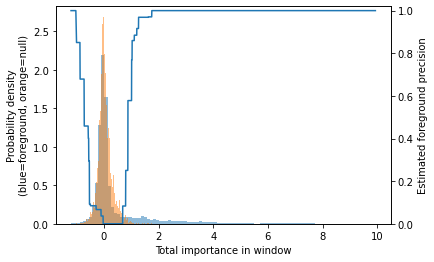

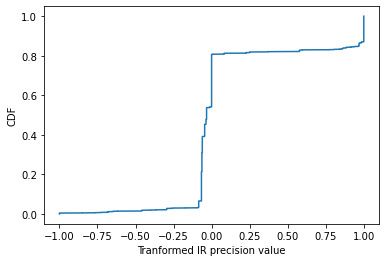

Thresholds from null dist were -0.85  and  0.85 with frac passing 0.17135
Got 639 coords
After resolving overlaps, got 639 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8499
MEMORY 0.652726272
639 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [597]
Idx to activities:  {0: '1'}
MEMORY 0.652726272
On metacluster 0
Metacluster size 597
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 597
(Round 1) Computing coarse affmat
MEMORY 0.652726272
Beginning embedding computation


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 181 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 578 out of 597 | elapsed:   13.1s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 597 out of 597 | elapsed:   13.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 340 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 578 out of 597 | elapsed:    9.2s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 597 out of 597 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 597 out of 597 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.14378023147583008 s


[Parallel(n_jobs=1)]: Done 597 out of 597 | elapsed:    1.4s finished


Constructing csr matrix...
csr matrix made in 0.1436150074005127 s
Finished embedding computation in 26.21 s
Starting affinity matrix computations
Batching in slices of size 500


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Batching in slices of size 500



100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

Finished affinity matrix computations in 3.55 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.691224576
Computed nearest neighbors in 0.03 s
MEMORY 0.6969344
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.6969344
Launching nearest neighbors affmat calculation job
MEMORY 0.696938496


Parallel runs completed
MEMORY 0.697053184
Job completed in: 1.17 s
MEMORY 0.697053184
Launching nearest neighbors affmat calculation job
MEMORY 0.697053184
Parallel runs completed
MEMORY 0.697061376
Job completed in: 1.17 s
MEMORY 0.697061376
(Round 1) Computed affinity matrix on nearest neighbors in 2.45 s
MEMORY 0.697069568
Filtered down to 422 of 597
(Round 1) Retained 422 rows out of 597 after filtering
MEMORY 0.697069568
(Round 1) Computing density adapted affmat
MEMORY 0.697069568
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 422 samples in 0.000s...
[t-SNE] Computed neighbors for 422 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 422 / 422
[t-SNE] Mean sigma: 0.377335
(Round 1) Computing clustering
MEMORY 0.69709824
Beginning preprocessing + Leiden


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.688869450647686


100%|██████████| 50/50 [00:03<00:00, 14.47it/s]

Got 11 clusters after round 1
Counts:
{7: 7, 4: 53, 3: 65, 1: 72, 5: 37, 0: 80, 2: 66, 9: 3, 8: 5, 6: 32, 10: 2}
MEMORY 0.697397248
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.697397248
Aggregating for cluster 0 with 80 seqlets
MEMORY 0.697397248


Trimming eliminated 0 seqlets out of 80
Skipped 5 seqlets
Skipped 1 seqlets
Aggregating for cluster 1 with 72 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 72
Skipped 10 seqlets
Removed 3 duplicate seqlets
Aggregating for cluster 2 with 66 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 66
Skipped 3 seqlets
Aggregating for cluster 3 with 65 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 65
Skipped 11 seqlets
Aggregating for cluster 4 with 53 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 53
Skipped 8 seqlets
Removed 4 duplicate seqlets
Aggregating for cluster 5 with 37 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 37
Skipped 1 seqlets
Aggregating for cluster 6 with 32 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 32
Skipped 5 seqlets
Aggregating for cluster 7 with 7 seqlets
MEMORY 0.697397248
Trimming eliminated 0 seqlets out of 7
Aggregating for cluster 8 with 5 seqlets
MEMORY 0.697

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 293 out of 312 | elapsed:    7.0s remaining:    0.5s
[Parallel(n_jobs=10)]: Done 312 out of 312 | elapsed:    7.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 293 out of 312 | elapsed:    6.9s remaining:    0.4s
[Parallel(n_jobs=10)]: Done 312 out of 312 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.06708884239196777 s
Constructing csr matrix...
csr matrix made in 0.06825685501098633 s
Finished embedding computation in 16.3 s
Starting affinity matrix computations
Batching in slices of size 500


[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:    0.8s finished
100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Batching in slices of size 500



100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

Finished affinity matrix computations in 1.78 s
(Round 2) Compute nearest neighbors from coarse affmat
MEMORY 0.697454592
Computed nearest neighbors in 0.01 s
MEMORY 0.697454592
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.697454592
Launching nearest neighbors affmat calculation job
MEMORY 0.697909248


Parallel runs completed
MEMORY 0.697909248
Job completed in: 0.74 s
MEMORY 0.697909248
Launching nearest neighbors affmat calculation job
MEMORY 0.697909248
Parallel runs completed
MEMORY 0.697909248
Job completed in: 0.6 s
MEMORY 0.697909248
(Round 2) Computed affinity matrix on nearest neighbors in 1.4 s
MEMORY 0.697909248
Not applying filtering for rounds above first round
MEMORY 0.697909248
(Round 2) Computing density adapted affmat
MEMORY 0.697909248
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 312 samples in 0.000s...
[t-SNE] Computed neighbors for 312 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 312 / 312
[t-SNE] Mean sigma: 0.419007
(Round 2) Computing clustering
MEMORY 0.697909248
Beginning preprocessing + Leiden


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6519505308172979


100%|██████████| 50/50 [00:02<00:00, 21.77it/s]

Got 15 clusters after round 2
Counts:
{0: 82, 8: 9, 5: 27, 14: 2, 13: 2, 1: 34, 2: 32, 7: 20, 6: 21, 9: 7, 11: 6, 4: 27, 10: 7, 3: 31, 12: 5}
MEMORY 0.697909248
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.697909248
Aggregating for cluster 0 with 82 seqlets
MEMORY 0.697909248


Trimming eliminated 0 seqlets out of 82
Skipped 1 seqlets
Aggregating for cluster 1 with 34 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 34
Removed 5 duplicate seqlets
Aggregating for cluster 2 with 32 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 32
Removed 10 duplicate seqlets
Aggregating for cluster 3 with 31 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 31
Skipped 1 seqlets
Aggregating for cluster 4 with 27 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 27
Aggregating for cluster 5 with 27 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 27
Aggregating for cluster 6 with 21 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 21
Removed 5 duplicate seqlets
Aggregating for cluster 7 with 20 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 20
Removed 5 duplicate seqlets
Aggregating for cluster 8 with 9 seqlets
MEMORY 0.697909248
Trimming eliminated 0 seqlets out of 9
Aggre

Performing seqlet reassignment
MEMORY 0.699150336
Cross contin jaccard time taken: 0.01 s
Cross contin jaccard time taken: 0.01 s
Discarded 7 seqlets
Skipped 4 seqlets
Skipped 9 seqlets
Skipped 3 seqlets
Skipped 9 seqlets
Skipped 2 seqlets
Got 2 patterns after reassignment
MEMORY 0.699334656
Total time taken is 71.67s
MEMORY 0.699334656


In [8]:
import h5py
import numpy as np
%matplotlib inline
import modisco

reload(modisco.coordproducers)
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
reload(modisco.seqlet_embedding)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=[5,9,13,17],
                    flank_size=5,
                    target_seqlet_fdr=0.15,
    
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        #Note: as of version 0.5.6.0, it's possible to use the results of a motif discovery
                        # software like MEME to improve the TF-MoDISco clustering. To use the meme-based
                        # initialization, you would specify the initclusterer_factory as shown in the
                        # commented-out code below:
                        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        #    meme_command="meme", base_outdir="meme_out",            
                        #    max_num_seqlets_to_use=10000, nmotifs=10, n_jobs=1),
                        
                        embedder_factory=(modisco.seqlet_embedding
                          .advanced_gapped_kmer.AdvancedGappedKmerEmbedderFactory()),
                        
                        nearest_neighbors_to_compute=50,
                         
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        #kmer_len=5, num_gaps=1,
                        #num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0"],# "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [9]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


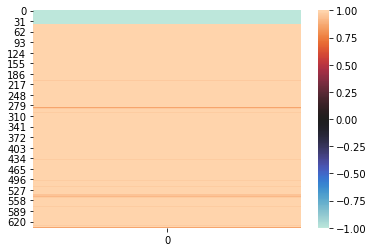

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 142
Task 0 hypothetical scores:


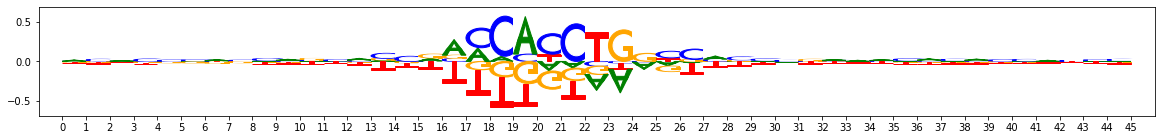

Task 0 actual importance scores:


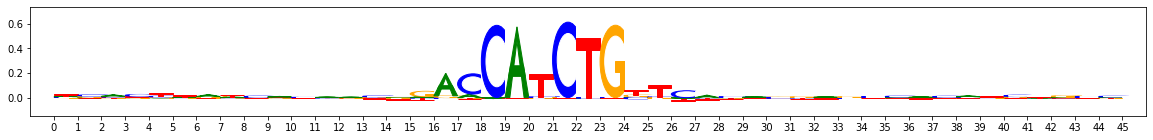

onehot, fwd and rev:


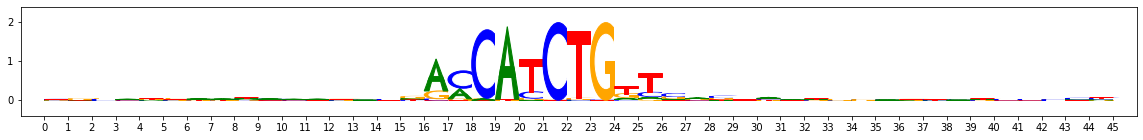

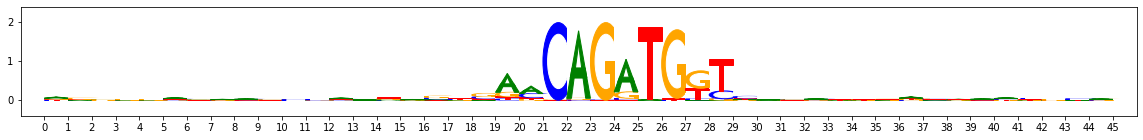

metacluster_0 pattern_1
total seqlets: 109
Task 0 hypothetical scores:


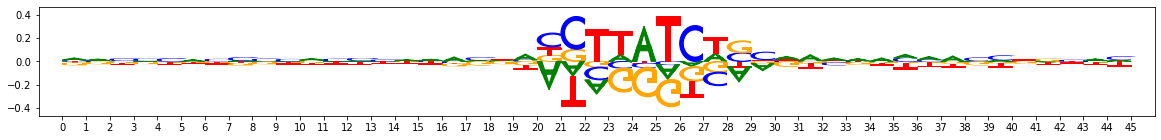

Task 0 actual importance scores:


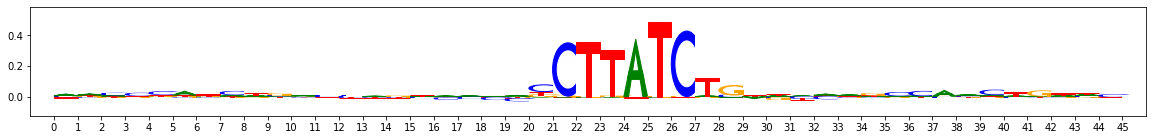

onehot, fwd and rev:


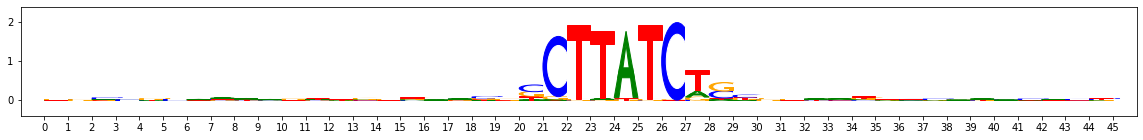

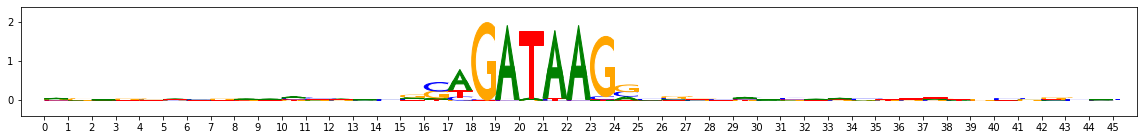

In [10]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        #print("Task 1 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        #print("Task 1 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        #print("Task 2 hypothetical scores:")
        #viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        #print("Task 2 actual importance scores:")
        #viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [11]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow
reload(modisco.tfmodisco_workflow.workflow)
reload(modisco.tfmodisco_workflow)
reload(modisco)
reload(modisco.core)
reload(modisco)

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Loaded sliding window sizes: [ 5  9 13 17]
For increasing = True , the minimum IR precision was 0.2954850349262155 occurring at 5.7220458984375e-06 implying a frac_neg of 0.41941626448668695
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.31974367348777494 occurring at 6.765127182006836e-06 implying a frac_neg of 0.47003410483096586
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.3469747405521833 occurring at 1.621246337890625e-05 implying a frac_neg of 0.5313343328335832
To be conservative, adjusted frac neg is 0.95
For increasing = True , the minimum IR precision was 0.40074974232407007 occurring at 6.67572021484375e-06 implying a frac_neg of 0.6687518898670086
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.35928651361524633 occurring at -5.638343282043934e-06 implying a frac_neg of 0.5607600296390388
To be conservative, adju

Getting the exemplar motifs
Numseqles: 142


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 142 out of 142 | elapsed:    5.1s finished


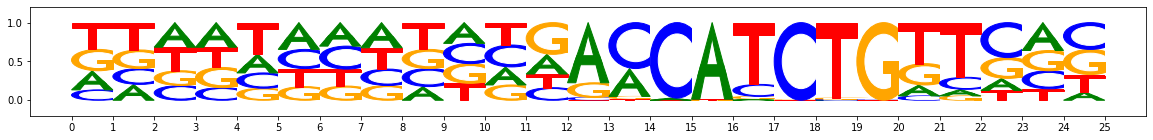

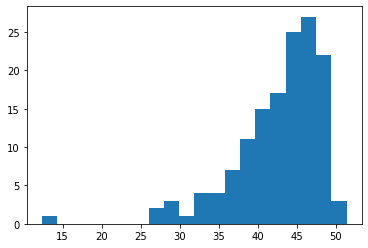

After filtering: numseqlets 141


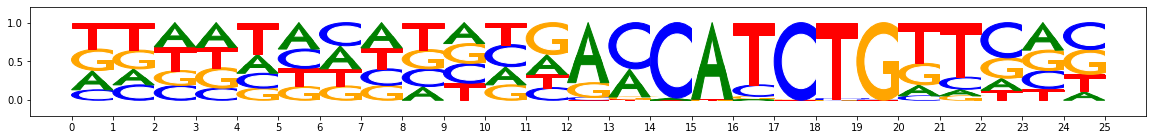

Numseqles: 109


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 109 out of 109 | elapsed:    0.1s finished


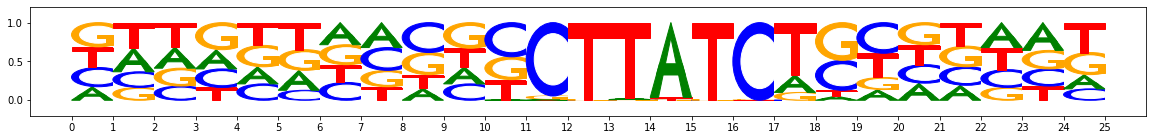

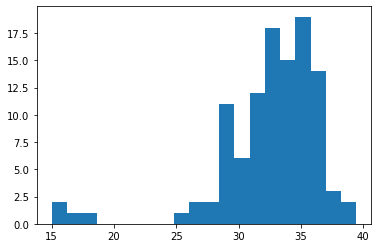

After filtering: numseqlets 105


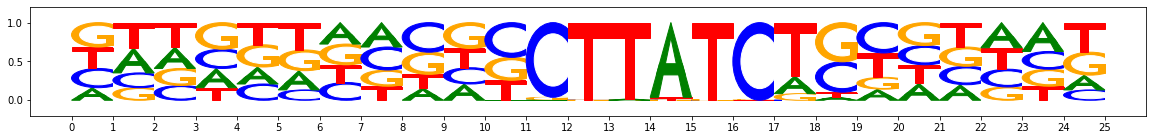

Getting labels
Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 5540 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 7376 out of 7376 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Took 0.35634303092956543 s


[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    0.2s finished


Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s


Took 0.3716139793395996 s


[Parallel(n_jobs=10)]: Done 5540 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 7376 out of 7376 | elapsed:    0.4s finished


In [12]:
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

SCANNING_WINDOW_WIDTH=25

instance_scorer = exemplar_based_hitscoring.prepare_instance_scorer(
    patterns=(loaded_tfmodisco_results
                .metacluster_idx_to_submetacluster_results["metacluster_0"]
                .seqlets_to_patterns_result.patterns),
    trim_window_size=SCANNING_WINDOW_WIDTH,
    task_names=tasks, bg_freq=background, track_set=track_set)

In [15]:
from collections import defaultdict
from modisco.hit_scoring import exemplar_based_hitscoring
reload(exemplar_based_hitscoring)

CUTOFF_VALUE = 0.2
coordinates_to_be_scanned, task0_transformed_scoretrack =\
    exemplar_based_hitscoring.get_windows_to_be_scanned(
        scanning_window_width=SCANNING_WINDOW_WIDTH,
        contrib_scores=task_to_scores["task0"],
        val_transformer=(loaded_tfmodisco_results.
            multitask_seqlet_creation_results.
            task_name_to_tnt_results["task0"].val_transformer),
        cutoff_value=CUTOFF_VALUE)
        

computing the transformed score track
done computing the transformed score track
Fraction of values above cutoff: 0.1872


In [16]:
reload(exemplar_based_hitscoring)

(motifmatch_to_coordinates,
 motifmatch_to_coordinatesbyregionidx,
 motif_scores, motif_precisions,
 besthit_isrevcomp) = (
 exemplar_based_hitscoring.scan_and_process_results(
    instance_scorer=instance_scorer, track_set=track_set,
    coordinates=coordinates_to_be_scanned))

Getting impscores data
Computing fwd sims


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 10220 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 29060 out of 29060 | elapsed:    1.0s finished


Took 1.0475728511810303 s


Index 0


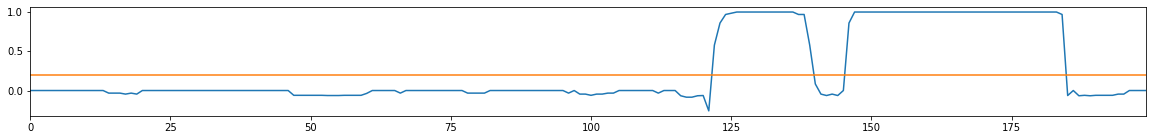

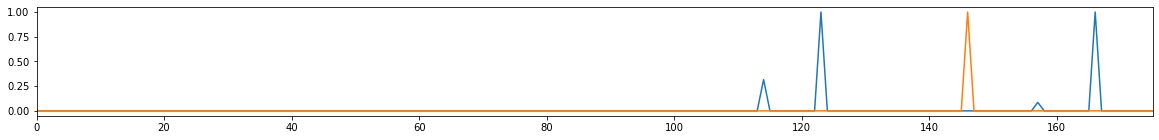

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6504827158037557, precision_at_motif_score=0.3163707407503883, example_idx=0, start=114, end=139, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.997667879007509, precision_at_motif_score=1.0, example_idx=0, start=123, end=148, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.5525896556967879, precision_at_motif_score=0.08588468275708364, example_idx=0, start=157, end=182, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.9986260150648937, precision_at_motif_score=1.0, example_idx=0, start=166, end=191, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9993490999238629, precision_at_motif_score=1.0, example_idx=0, start=146, end=171, is_revcomp=True)


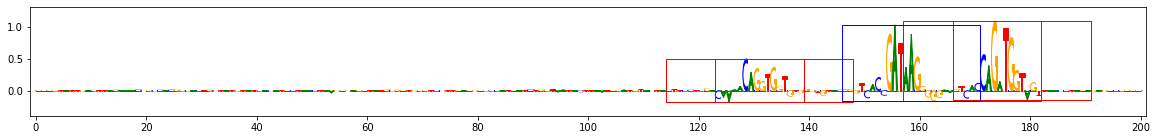

Index 1


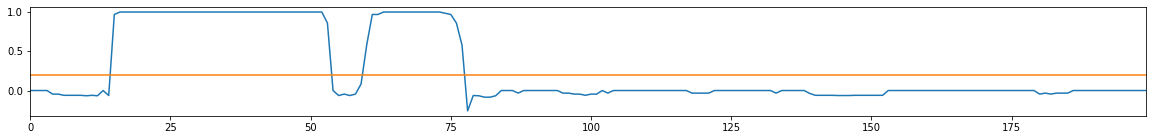

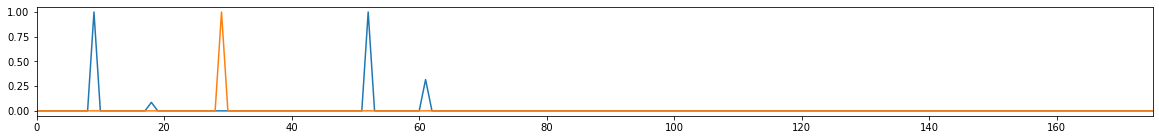

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.9986260150648937, precision_at_motif_score=1.0, example_idx=1, start=9, end=34, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.5525896556967879, precision_at_motif_score=0.08588468275708364, example_idx=1, start=18, end=43, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.997667879007509, precision_at_motif_score=1.0, example_idx=1, start=52, end=77, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.6504827158037557, precision_at_motif_score=0.3163707407503883, example_idx=1, start=61, end=86, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9993490999238629, precision_at_motif_score=1.0, example_idx=1, start=29, end=54, is_revcomp=False)


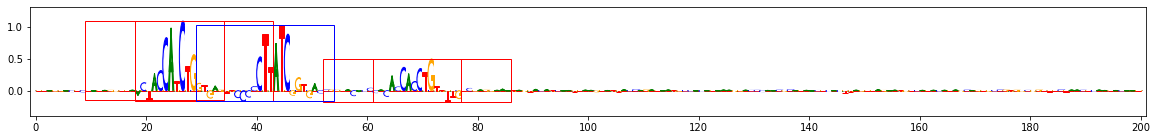

Index 2


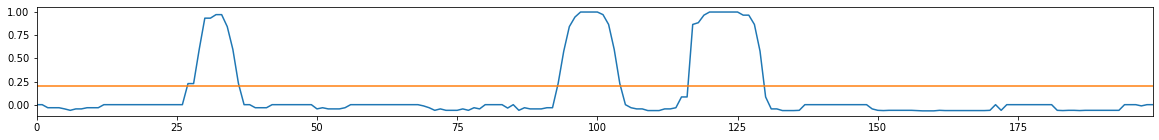

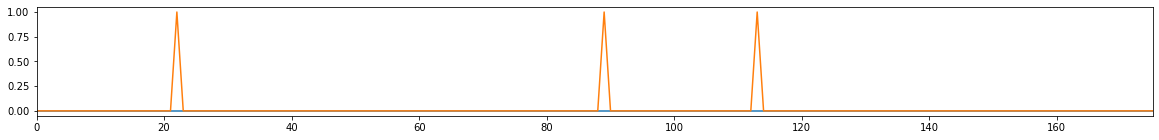

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9933627532372303, precision_at_motif_score=1.0, example_idx=2, start=22, end=47, is_revcomp=True)
MotifHitAndCoord(motif_idx=1, motif_score=0.998124872090949, precision_at_motif_score=1.0, example_idx=2, start=89, end=114, is_revcomp=True)
MotifHitAndCoord(motif_idx=1, motif_score=0.9994427100002803, precision_at_motif_score=1.0, example_idx=2, start=113, end=138, is_revcomp=True)


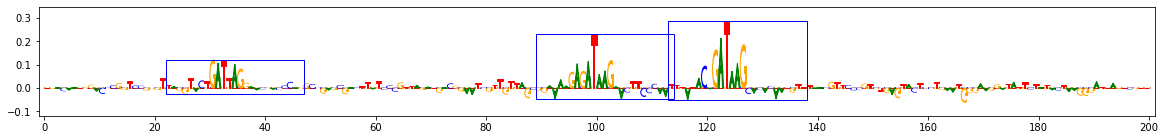

Index 3


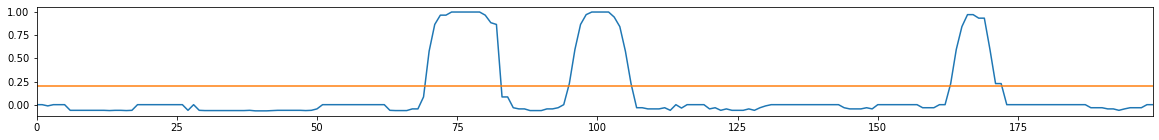

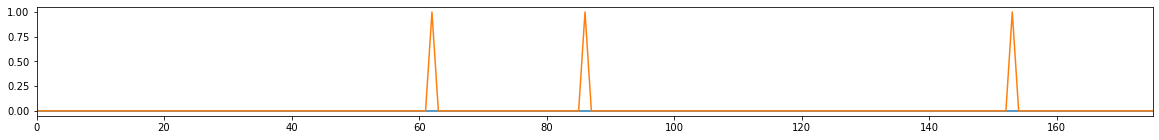

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9994427100002803, precision_at_motif_score=1.0, example_idx=3, start=62, end=87, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.998124872090949, precision_at_motif_score=1.0, example_idx=3, start=86, end=111, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9933627532372303, precision_at_motif_score=1.0, example_idx=3, start=153, end=178, is_revcomp=False)


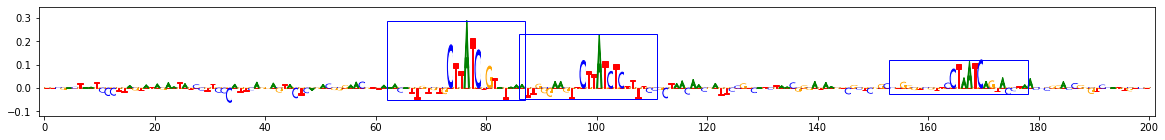

Index 4


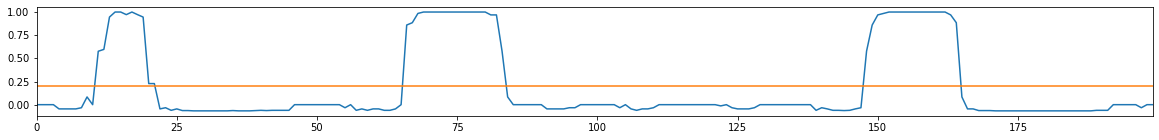

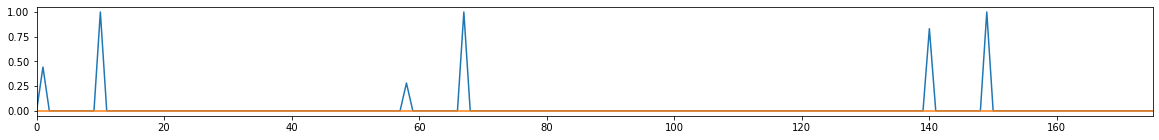

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.704276474569764, precision_at_motif_score=0.44302641367625195, example_idx=4, start=1, end=26, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.9952651939732524, precision_at_motif_score=1.0, example_idx=4, start=10, end=35, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.635539514810006, precision_at_motif_score=0.28118745516214005, example_idx=4, start=58, end=83, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.9995073050902686, precision_at_motif_score=1.0, example_idx=4, start=67, end=92, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.8856687419902738, precision_at_motif_score=0.8314828431175738, example_idx=4, start=140, end=165, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.999818566464115, precision_at_motif_score=1.0, example_idx=4, start=149, end=174, is_revcomp=True)
gata hits:



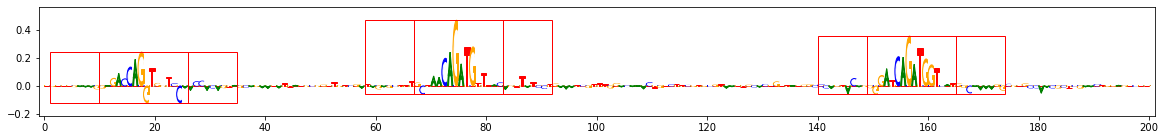

Index 5


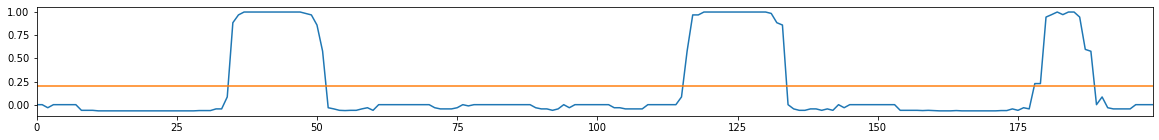

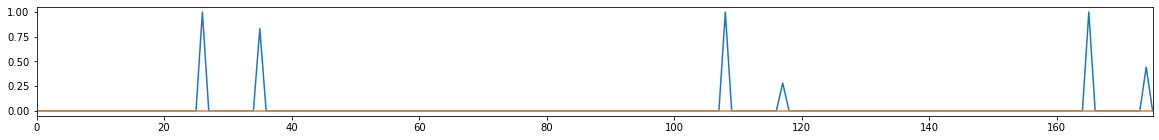

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.999818566464115, precision_at_motif_score=1.0, example_idx=5, start=26, end=51, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.8856687419902738, precision_at_motif_score=0.8314828431175738, example_idx=5, start=35, end=60, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9995073050902686, precision_at_motif_score=1.0, example_idx=5, start=108, end=133, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.635539514810006, precision_at_motif_score=0.28118745516214005, example_idx=5, start=117, end=142, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9952651939732524, precision_at_motif_score=1.0, example_idx=5, start=165, end=190, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.704276474569764, precision_at_motif_score=0.44302641367625195, example_idx=5, start=174, end=199, is_revcomp=True)
gata hits:



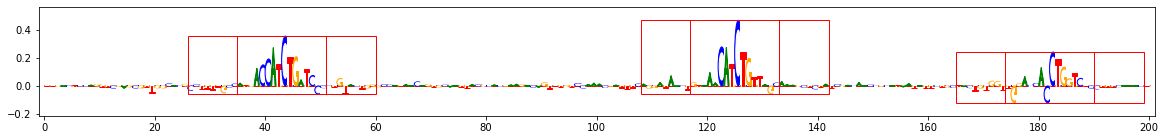

Index 6


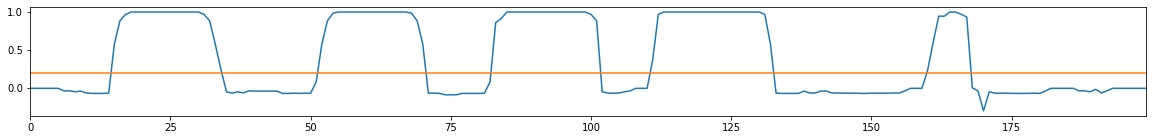

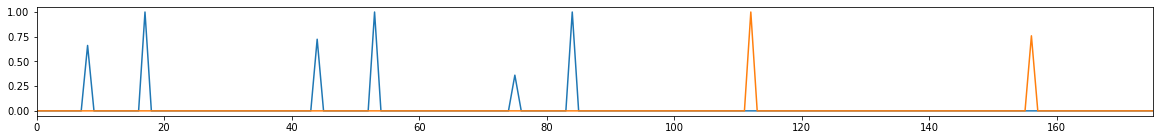

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.8114523781844735, precision_at_motif_score=0.6617643108541413, example_idx=6, start=8, end=33, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.9988489961840756, precision_at_motif_score=1.0, example_idx=6, start=17, end=42, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.8389726480891654, precision_at_motif_score=0.7246978685792207, example_idx=6, start=44, end=69, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.9998068744229901, precision_at_motif_score=1.0, example_idx=6, start=53, end=78, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.6694922206103467, precision_at_motif_score=0.3611280077363049, example_idx=6, start=75, end=100, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.9995233787592409, precision_at_motif_score=1.0, example_idx=6, start=84, end=109, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9998292111100581, precision_at_mot

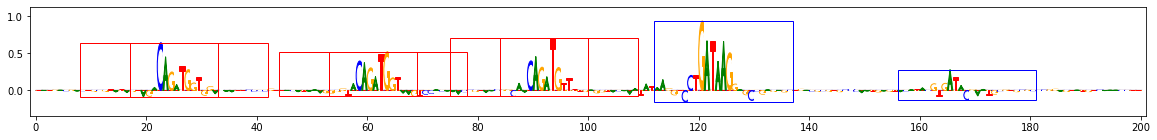

Index 7


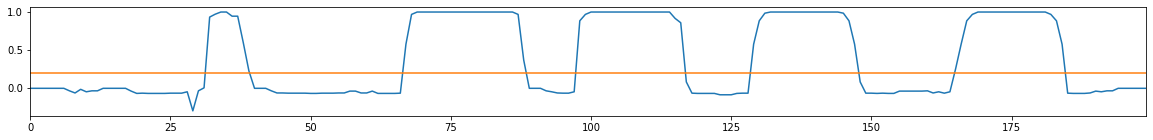

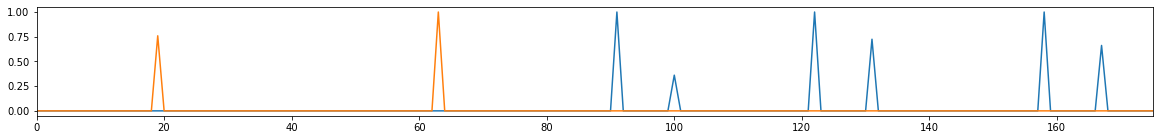

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.9995233787592409, precision_at_motif_score=1.0, example_idx=7, start=91, end=116, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.6694922206103467, precision_at_motif_score=0.3611280077363049, example_idx=7, start=100, end=125, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9998068744229901, precision_at_motif_score=1.0, example_idx=7, start=122, end=147, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.8389726480891654, precision_at_motif_score=0.7246978685792207, example_idx=7, start=131, end=156, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.9988489961840756, precision_at_motif_score=1.0, example_idx=7, start=158, end=183, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.8114523781844735, precision_at_motif_score=0.6617643108541413, example_idx=7, start=167, end=192, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.8404588409236708, precis

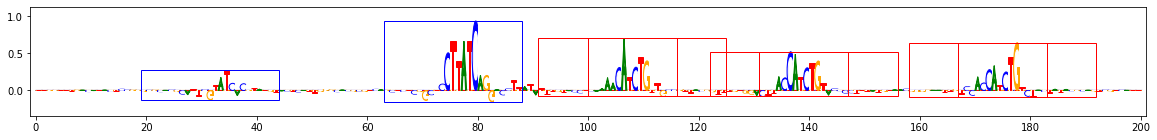

Index 8


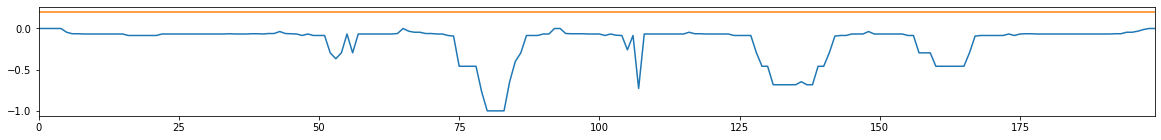

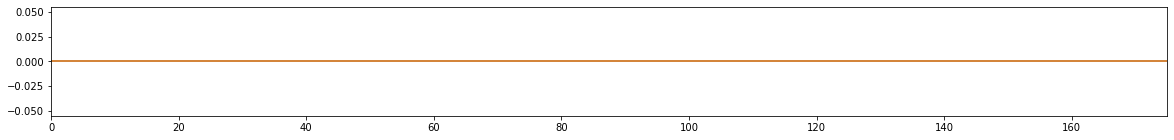

tal hits:

gata hits:



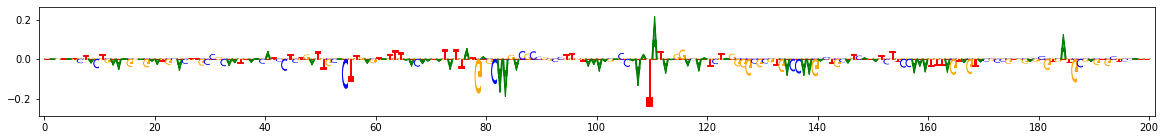

Index 9


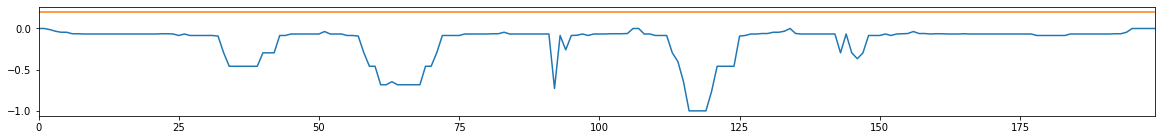

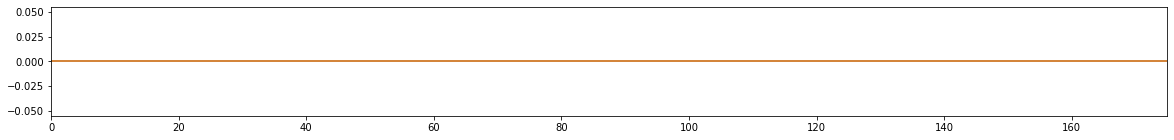

tal hits:

gata hits:



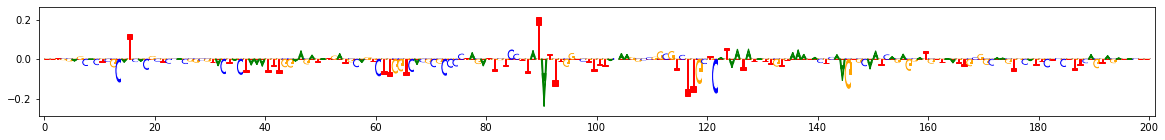

Index 10


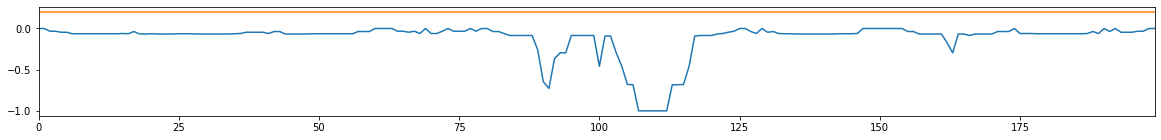

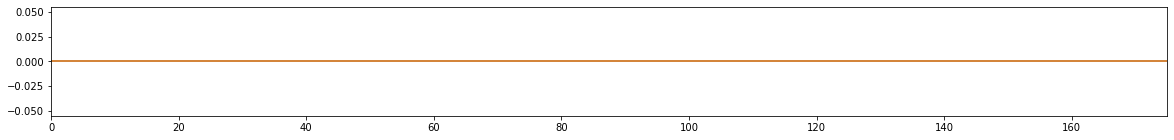

tal hits:

gata hits:



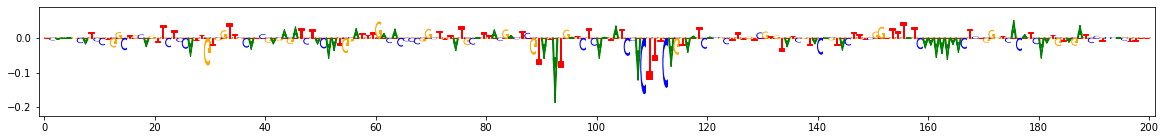

Index 11


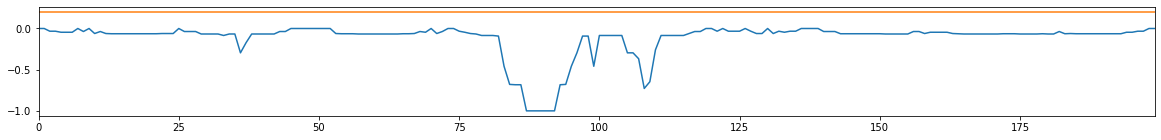

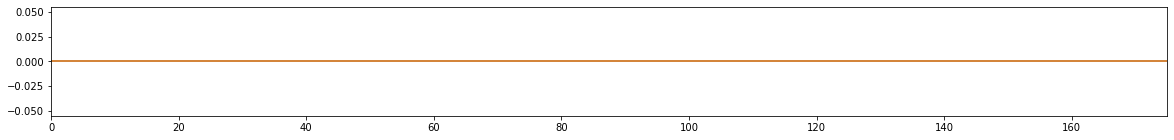

tal hits:

gata hits:



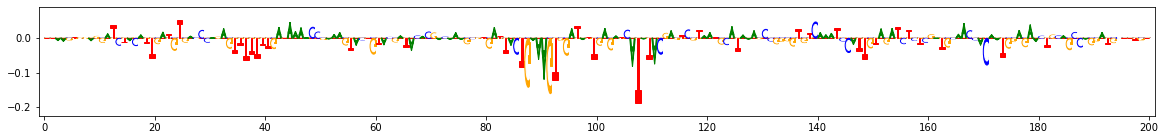

Index 12


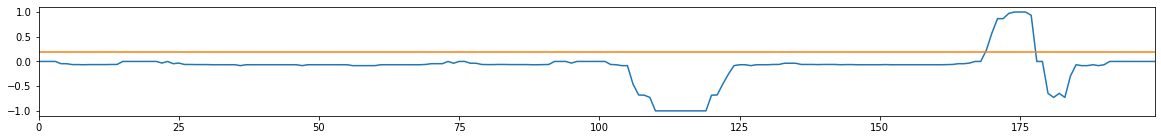

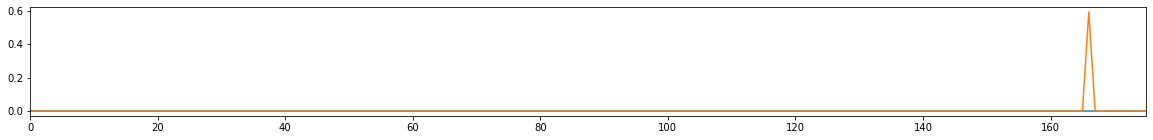

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.7484393570283403, precision_at_motif_score=0.5937741511866684, example_idx=12, start=166, end=191, is_revcomp=True)


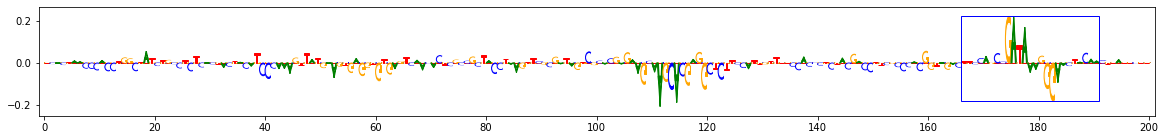

Index 13


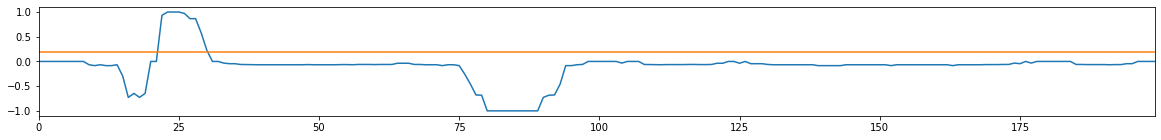

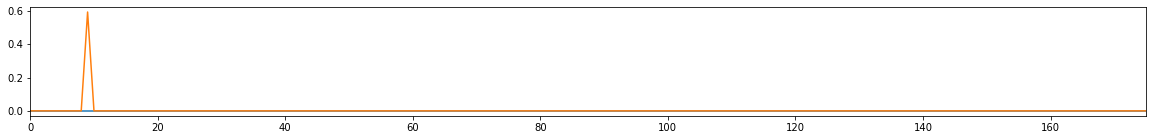

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.7484393570283403, precision_at_motif_score=0.5937741511866684, example_idx=13, start=9, end=34, is_revcomp=False)


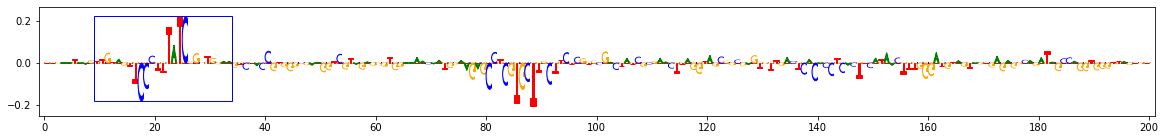

Index 14


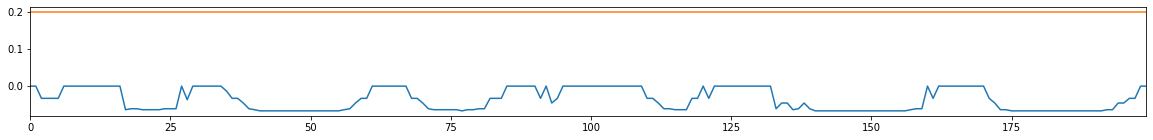

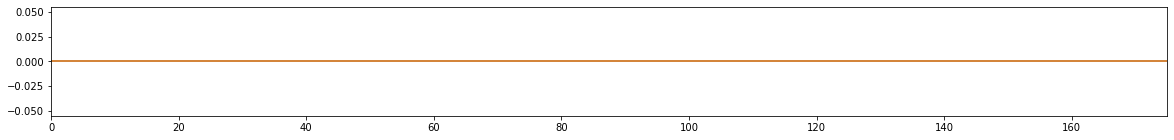

tal hits:

gata hits:



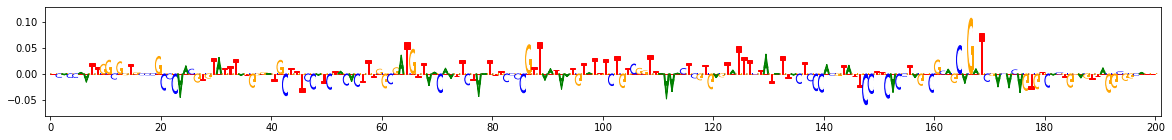

Index 15


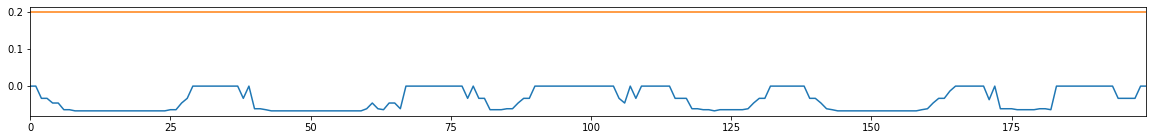

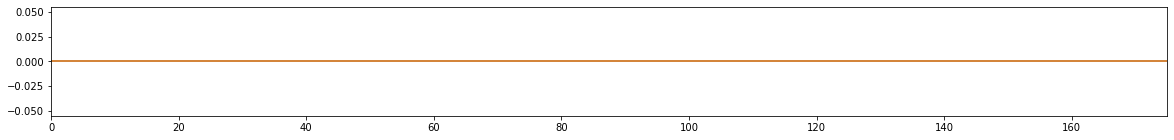

tal hits:

gata hits:



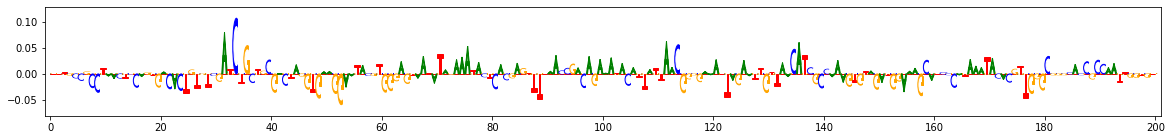

Index 16


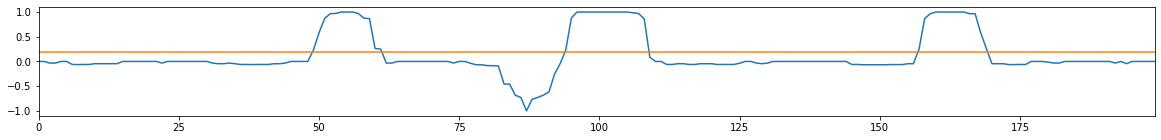

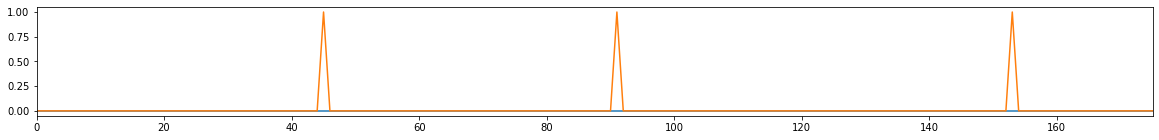

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9971336414418648, precision_at_motif_score=1.0, example_idx=16, start=45, end=70, is_revcomp=True)
MotifHitAndCoord(motif_idx=1, motif_score=0.9997176352865069, precision_at_motif_score=1.0, example_idx=16, start=91, end=116, is_revcomp=True)
MotifHitAndCoord(motif_idx=1, motif_score=0.9992547815607424, precision_at_motif_score=1.0, example_idx=16, start=153, end=178, is_revcomp=True)


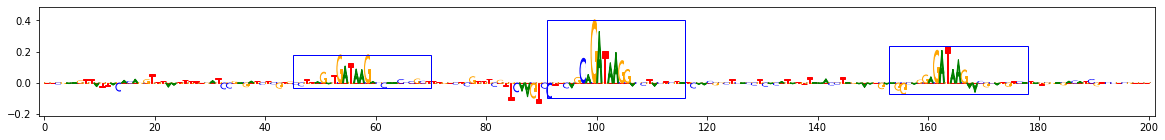

Index 17


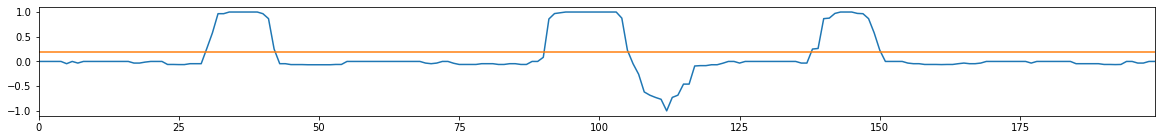

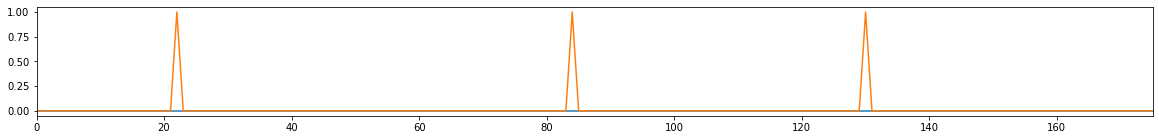

tal hits:

gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9992547815607424, precision_at_motif_score=1.0, example_idx=17, start=22, end=47, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9997176352865069, precision_at_motif_score=1.0, example_idx=17, start=84, end=109, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9971336414418648, precision_at_motif_score=1.0, example_idx=17, start=130, end=155, is_revcomp=False)


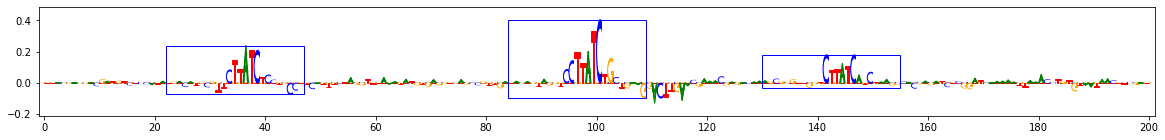

Index 18


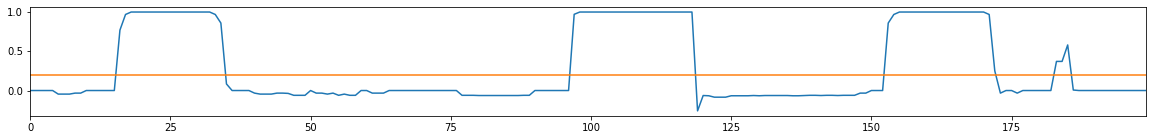

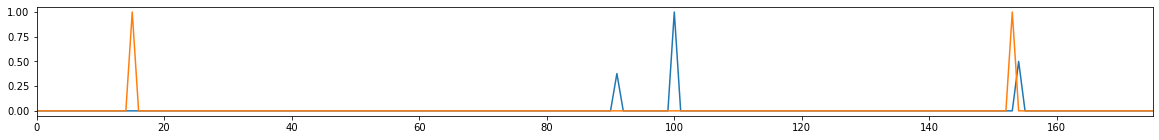

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.6763298538561408, precision_at_motif_score=0.3772269950506758, example_idx=18, start=91, end=116, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.999585467994209, precision_at_motif_score=1.0, example_idx=18, start=100, end=125, is_revcomp=True)
MotifHitAndCoord(motif_idx=0, motif_score=0.7407143227403524, precision_at_motif_score=0.5, example_idx=18, start=154, end=179, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9927436977742843, precision_at_motif_score=1.0, example_idx=18, start=15, end=40, is_revcomp=True)
MotifHitAndCoord(motif_idx=1, motif_score=0.9955978570801688, precision_at_motif_score=1.0, example_idx=18, start=153, end=178, is_revcomp=True)


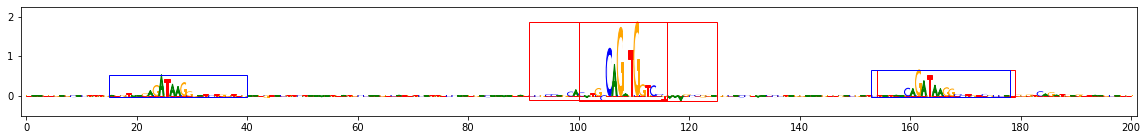

Index 19


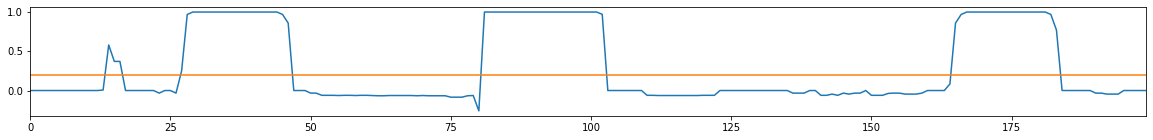

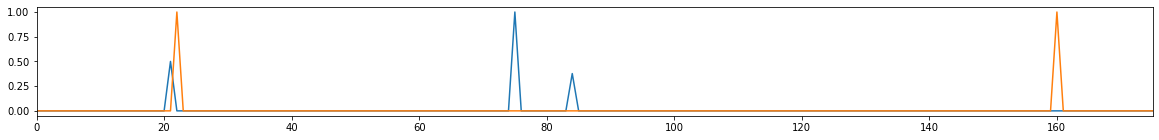

tal hits:
MotifHitAndCoord(motif_idx=0, motif_score=0.7407143227403524, precision_at_motif_score=0.5, example_idx=19, start=21, end=46, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.999585467994209, precision_at_motif_score=1.0, example_idx=19, start=75, end=100, is_revcomp=False)
MotifHitAndCoord(motif_idx=0, motif_score=0.6763298538561408, precision_at_motif_score=0.3772269950506758, example_idx=19, start=84, end=109, is_revcomp=True)
gata hits:
MotifHitAndCoord(motif_idx=1, motif_score=0.9955978570801688, precision_at_motif_score=1.0, example_idx=19, start=22, end=47, is_revcomp=False)
MotifHitAndCoord(motif_idx=1, motif_score=0.9927436977742843, precision_at_motif_score=1.0, example_idx=19, start=160, end=185, is_revcomp=False)


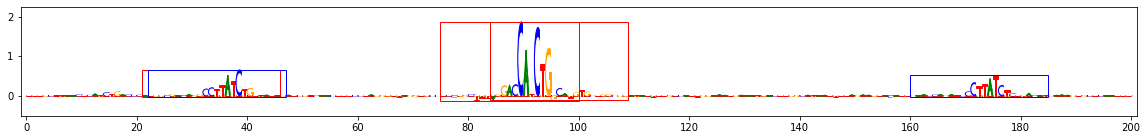

In [24]:
reload(modisco.visualization.viz_sequence)
reload(modisco.visualization)
from matplotlib import pyplot as plt

def visualize_idx(idx_to_viz):
    viz_sequence.plot_score_track(task0_transformed_scoretrack[idx_to_viz],
                                  threshold=CUTOFF_VALUE)
    
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)
    viz_sequence.plot_score_track_given_ax(arr=motif_precisions[idx_to_viz][:,0], ax=ax) #tal score plot (start idx)
    viz_sequence.plot_score_track_given_ax(arr=motif_precisions[idx_to_viz][:,1], ax=ax) #gata score plot (start idx)
    plt.show()
    
    print("tal hits:\n"+"\n".join([str(x) for x in motifmatch_to_coordinatesbyregionidx[0][idx_to_viz]]))
    print("gata hits:\n"+"\n".join([str(x) for x in motifmatch_to_coordinatesbyregionidx[1][idx_to_viz]]))
    viz_sequence.plot_weights(task_to_scores["task0"][idx_to_viz],
                              highlight={
                                  'red': [(x.start, x.end) for x in
                                          motifmatch_to_coordinatesbyregionidx[0][idx_to_viz]],
                                  'blue': [(x.start, x.end) for x in
                                          motifmatch_to_coordinatesbyregionidx[1][idx_to_viz]]
                              },
                              subticks_frequency=20)

for idx_to_viz in range(20):
    print("Index",idx_to_viz)
    visualize_idx(idx_to_viz)